In [2]:
import torch
import os
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

2024-12-12 03:15:01.416145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733994901.437125  488508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733994901.443396  488508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 03:15:01.468058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


# Define Albumentations augmentations
def augment_image(image):
    aug = A.Compose([
        A.Resize(256, 256),  # Resize images to a slightly larger size
        A.CenterCrop(224, 224),  # Crop the central part
        A.CLAHE(clip_limit=4.0, p=0.5),  # Improve contrast
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust color properties
        A.Blur(blur_limit=3, p=0.3),  # Apply slight blur for robustness
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Add Gaussian noise
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
        ToTensorV2()  # Convert to PyTorch tensor
    ])
    augmented = aug(image=image)
    return augmented['image']


class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Convert PIL to NumPy
        img = augment_image(img)
        return img, label


# Paths to datasets
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'
test_path = 'chest_xray/test'

# Load datasets with Albumentations
trainset = AlbumentationsDataset(ImageFolder(root=train_path))
valset = AlbumentationsDataset(ImageFolder(root=val_path))
testset = AlbumentationsDataset(ImageFolder(root=test_path))

# Calculate class weights for oversampling
train_labels = [label for _, label in trainset]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts  # Weight inversely proportional to class frequency
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler for oversampling
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train = DataLoader(trainset, batch_size=64, sampler=sampler, num_workers=4, pin_memory=True)
valid = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

print("DataLoaders created with oversampling for training.")


DataLoaders created with oversampling for training.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers with Batch Normalization and Dropout
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)  # Dropout after the first layer

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)  # Dropout after the second layer

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)  # Dropout after the third layer

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.25)  # Dropout after the fourth layer

        # Fully connected layers with Batch Normalization and Dropout
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout for fully connected layer
        self.fc2 = nn.Linear(512, 1)  # Binary classification

    def forward(self, x):
        # Apply each conv, batch norm, activation, pool, and dropout layer sequentially
        x = self.pool1(self.dropout1(torch.relu(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(torch.relu(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(torch.relu(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(torch.relu(self.bn4(self.conv4(x)))))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = torch.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)  # Dropout after first fully connected layer
        x = self.fc2(x)  # Output layer, raw scores for each class

        return x


In [5]:
device = torch.device("cuda")
model = CNN().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F  # For softmax

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 15
epoch_counter = 0
# Early Stopping Class with Restore Best Weights Option and Best Epoch Tracking
class EarlyStopping:
    def __init__(self, patience=20, verbose=1, min_delta=0.001, mode='min', restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None  # To store the best model weights
        self.best_epoch = 0  # To track the best epoch

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save initial model state
            self.best_epoch = epoch
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save best model state
            self.best_epoch = epoch  # Update best epoch
            self.counter = 0  # Reset counter if there's an improvement
        else:
            self.counter += 1  # Increment if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    print(f"Restoring model weights from the end of the best epoch: {self.best_epoch + 1}.")
                    model.load_state_dict(self.best_model_weights)

# Initialize early stopping and learning rate scheduler
early_stopping = EarlyStopping(patience=8, min_delta=0.001)

# Wrap model in DataParallel for multi-GPU usage
model = nn.DataParallel(model)  # Add this to utilize multiple GPUs
model = model.to(device)

# Ensure the optimizer and scheduler are correctly set after DataParallel
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, verbose=1, steps_per_epoch=len(train), epochs=num_epochs)

best_val_loss = float('inf')  # For saving the best model based on validation loss

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_counter += 1
    for i, (inputs, targets) in enumerate(train):
        inputs = inputs.to(device)
        targets = targets.float().view(-1, 1).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy for training
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
        
        # Print intermediate loss and accuracy every 32 batches
        if i % 32 == 0:
            batch_accuracy = 100 * correct_train / total_train
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train)}, Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.2f}%")
    
    # End of epoch training accuracy and loss
    epoch_train_loss = running_loss / len(train)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid:
            inputs = inputs.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy (categorical accuracy)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(valid)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%")
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss


    # Early stopping check and restore weights if triggered
    early_stopping(epoch_val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training, print the best epoch if early stopping was not triggered
if not early_stopping.early_stop and early_stopping.restore_best_weights:
    print(f"Training completed. Restoring model weights from the end of the best epoch: {early_stopping.best_epoch + 1}.")
    model.load_state_dict(early_stopping.best_model_weights)


Epoch 1, Batch 1/82, Loss: 0.7841, Accuracy: 51.56%
Epoch 1, Batch 33/82, Loss: 0.6529, Accuracy: 54.59%
Epoch 1, Batch 65/82, Loss: 0.4147, Accuracy: 61.68%
Epoch 1/15, Train Loss: 0.5963, Train Accuracy: 65.22%, Val Loss: 0.7280, Val Accuracy: 50.00%
Epoch 2, Batch 1/82, Loss: 0.5475, Accuracy: 78.12%
Epoch 2, Batch 33/82, Loss: 0.4819, Accuracy: 82.81%
Epoch 2, Batch 65/82, Loss: 0.3374, Accuracy: 83.85%
Epoch 2/15, Train Loss: 0.3474, Train Accuracy: 84.22%, Val Loss: 0.4968, Val Accuracy: 81.25%
Epoch 3, Batch 1/82, Loss: 0.3207, Accuracy: 85.94%
Epoch 3, Batch 33/82, Loss: 0.1668, Accuracy: 86.36%
Epoch 3, Batch 65/82, Loss: 0.3002, Accuracy: 86.08%
Epoch 3/15, Train Loss: 0.3201, Train Accuracy: 86.04%, Val Loss: 0.4703, Val Accuracy: 75.00%
Epoch 4, Batch 1/82, Loss: 0.3266, Accuracy: 84.38%
Epoch 4, Batch 33/82, Loss: 0.2058, Accuracy: 85.09%
Epoch 4, Batch 65/82, Loss: 0.1947, Accuracy: 85.96%
Epoch 4/15, Train Loss: 0.3051, Train Accuracy: 85.97%, Val Loss: 0.3021, Val Accur

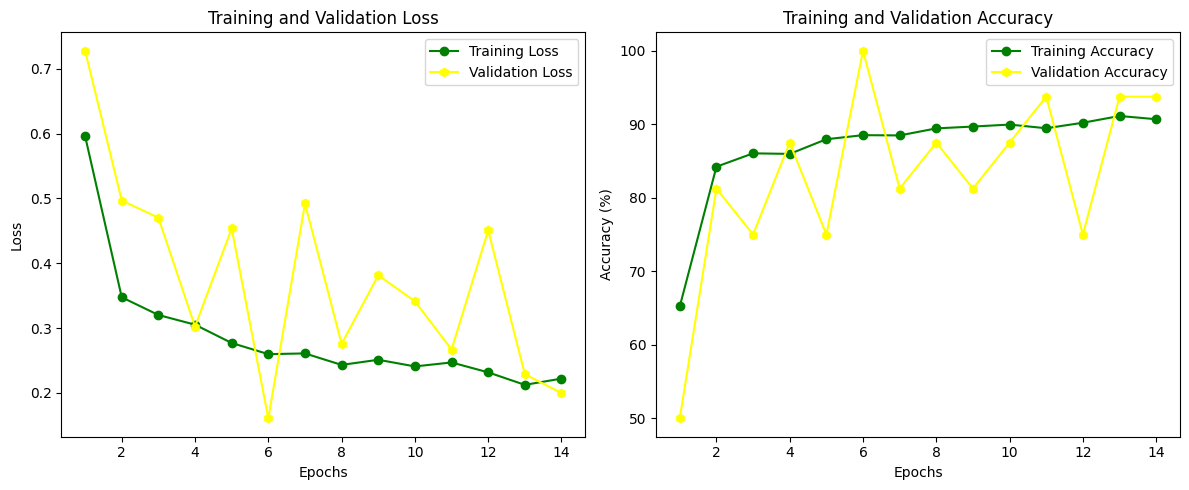

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_counter), train_losses, label='Training Loss',color='green', marker='o')
plt.plot(range(1, epoch_counter), val_losses, label='Validation Loss',color='yellow', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_counter), train_accuracies, label='Training Accuracy',color='green', marker='o')
plt.plot(range(1, epoch_counter), val_accuracies, label='Validation Accuracy',color='yellow', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


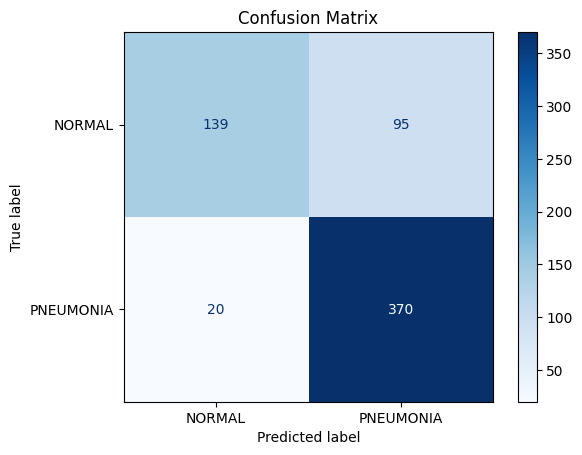

              precision    recall  f1-score   support

      Normal       0.86      0.59      0.70       234
   Pneumonia       0.79      0.94      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.77      0.78       624
weighted avg       0.82      0.81      0.80       624



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))


In [11]:
torch.cuda.empty_cache()  # Free up GPU memory cache

In [13]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


# Define Albumentations augmentations
def augment_image(image):
    aug = A.Compose([
        A.Resize(256, 256),  # Resize images to a slightly larger size
        A.CenterCrop(224, 224),  # Crop the central part
        A.CLAHE(clip_limit=4.0, p=0.5),  # Improve contrast
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust color properties
        A.Blur(blur_limit=3, p=0.3),  # Apply slight blur for robustness
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Add Gaussian noise
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
        ToTensorV2()  # Convert to PyTorch tensor
    ])
    augmented = aug(image=image)
    return augmented['image']


class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Convert PIL to NumPy
        img = augment_image(img)
        return img, label


# Paths to datasets
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'
test_path = 'chest_xray/test'


# Load datasets with Albumentations
trainset = AlbumentationsDataset(ImageFolder(root=train_path))
valset = AlbumentationsDataset(ImageFolder(root=val_path))
testset = AlbumentationsDataset(ImageFolder(root=test_path))

# Calculate class weights for oversampling
train_labels = [label for _, label in trainset]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts  # Weight inversely proportional to class frequency
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler for oversampling
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

print("DataLoaders created with oversampling for training.")

DataLoaders created with oversampling for training.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pretrained EfficientNet-B7 model
model = models.efficientnet_b7(pretrained=True)

# Replace the classifier for binary classification
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 1)  # Output for binary classification
)

# Check device
device = torch.device('cuda')
num_gpus = torch.cuda.device_count()
model = nn.DataParallel(model)  # Add this to utilize multiple GPUs
model = model.to(device)

# Freeze feature extractor
for param in model.module.features.parameters():  # Use .module to access the actual model
    param.requires_grad = False


# Define criterion and optimizer for the classifier
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.module.classifier.parameters(), lr=0.001)  # Only update classifier parameters

print(f"Using {num_gpus} GPUs")


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /home/zri6387/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 215MB/s] 


Using 8 GPUs


In [15]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, mode='min', restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None
        self.best_epoch = 0
        self.restore_best_weights = restore_best_weights

    def __call__(self, val_loss, model, current_epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
            self.counter = 0

    def restore_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)




# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 10
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Restore the best model weights
early_stopping.restore_weights(model)

# Print the best epoch
print(f"Best epoch based on validation loss: {early_stopping.best_epoch}")

Epoch [1/10] - Train Loss: 0.5305, Train Acc: 0.7634, Val Loss: 0.4423, Val Acc: 0.7500
Epoch [2/10] - Train Loss: 0.4474, Train Acc: 0.7968, Val Loss: 0.4382, Val Acc: 0.8750
Epoch [3/10] - Train Loss: 0.4212, Train Acc: 0.8115, Val Loss: 0.3994, Val Acc: 0.8125
Epoch [4/10] - Train Loss: 0.3993, Train Acc: 0.8183, Val Loss: 0.5330, Val Acc: 0.7500
Epoch [5/10] - Train Loss: 0.3942, Train Acc: 0.8253, Val Loss: 0.6426, Val Acc: 0.6875
Epoch [6/10] - Train Loss: 0.3929, Train Acc: 0.8213, Val Loss: 0.3903, Val Acc: 0.8750
Epoch [7/10] - Train Loss: 0.4016, Train Acc: 0.8175, Val Loss: 0.5865, Val Acc: 0.6250
Epoch [8/10] - Train Loss: 0.3914, Train Acc: 0.8198, Val Loss: 0.6599, Val Acc: 0.6250
Epoch [9/10] - Train Loss: 0.3982, Train Acc: 0.8173, Val Loss: 0.6198, Val Acc: 0.6250
Epoch [10/10] - Train Loss: 0.3802, Train Acc: 0.8328, Val Loss: 0.5019, Val Acc: 0.8750
Best epoch based on validation loss: 6


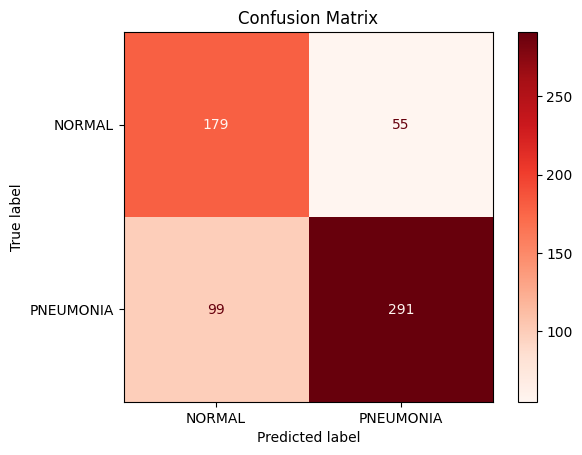

              precision    recall  f1-score   support

      Normal       0.68      0.76      0.72       234
   Pneumonia       0.85      0.78      0.81       390

    accuracy                           0.78       624
   macro avg       0.76      0.77      0.77       624
weighted avg       0.78      0.78      0.78       624



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))

In [17]:
# Unfreeze the entire model
for param in model.module.features.parameters():  # Use .module to access the actual model
    param.requires_grad = True

# Define a new optimizer with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, mode='min', restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None
        self.best_epoch = 0
        self.restore_best_weights = restore_best_weights

    def __call__(self, val_loss, model, current_epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
            self.counter = 0

    def restore_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)




# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 10
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Restore the best model weights
early_stopping.restore_weights(model)

# Print the best epoch
print(f"Best epoch based on validation loss: {early_stopping.best_epoch}")


Epoch [1/10] - Train Loss: 0.3074, Train Acc: 0.8702, Val Loss: 0.0920, Val Acc: 1.0000
Epoch [2/10] - Train Loss: 0.1418, Train Acc: 0.9442, Val Loss: 0.3246, Val Acc: 0.8750
Epoch [3/10] - Train Loss: 0.0895, Train Acc: 0.9680, Val Loss: 0.2403, Val Acc: 0.9375
Epoch [4/10] - Train Loss: 0.0717, Train Acc: 0.9735, Val Loss: 0.0539, Val Acc: 1.0000
Epoch [5/10] - Train Loss: 0.0488, Train Acc: 0.9827, Val Loss: 0.1564, Val Acc: 0.8750
Epoch [6/10] - Train Loss: 0.0474, Train Acc: 0.9835, Val Loss: 0.0200, Val Acc: 1.0000
Epoch [7/10] - Train Loss: 0.0378, Train Acc: 0.9875, Val Loss: 0.1373, Val Acc: 0.9375
Epoch [8/10] - Train Loss: 0.0254, Train Acc: 0.9923, Val Loss: 0.0381, Val Acc: 1.0000
Epoch [9/10] - Train Loss: 0.0352, Train Acc: 0.9891, Val Loss: 0.1567, Val Acc: 0.9375
Epoch [10/10] - Train Loss: 0.0310, Train Acc: 0.9904, Val Loss: 0.1328, Val Acc: 0.9375
Best epoch based on validation loss: 6


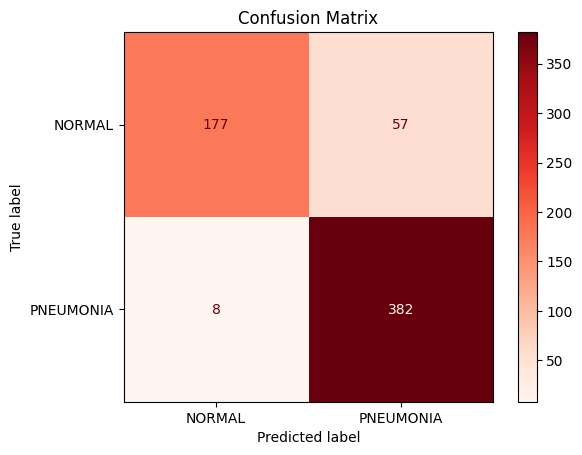

              precision    recall  f1-score   support

      Normal       0.96      0.77      0.86       234
   Pneumonia       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))
